In [4]:
from collections import defaultdict
from functools import reduce
from itertools import product, combinations
from time import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [43]:
n_units = 3
data = np.random.binomial(n=1, p=np.random.uniform(size=n_units), size=(100, n_units))
all_configs = list(product([0, 1], repeat=n_units))
alpha = .001

biases = np.random.randn(n_units)
weights = np.random.randn(n_units, n_units)

var_combinations = list(combinations(range(n_units), 2))


def reset_parameters():
    np.random.seed(42)
    biases = np.random.randn(n_units)
    weights = np.random.randn(n_units, n_units)
    return weights, biases

In [44]:
class Model:
    
    def __init__(self, weights, biases):
        self.weights = weights
        self.biases = biases
        
    def H(self, x):
        h = 0
        for i, j in var_combinations:
            h += self.weights[i, j] * x[i] * x[j]
        h += self.biases @ x
        return h
    
    def _unnormalized_likelihood(self, x):
        return np.exp(self.H(x))
    
    def marginal_likelihood(self, x):
        unnormalized_lik = 0
        for config in product(*[[0, 1] if el == ... else [el] for el in x]):
            config = np.array(config)
            unnormalized_lik += np.exp(self.H(config))
        return unnormalized_lik
    
    def likelihood(self, x, log=False):
        """
        Must have the dimensionality of the data observations. To marginalize, put ellipses (...)
        in the elements over which you wish to marginalize.
        """
        x = np.array(x)
        if not n_units in x.shape and len(x.shape) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        # compute partition function
        Z = sum([self._unnormalized_likelihood(config) for config in all_configs])
        
        if log:
            return sum([np.log(lik) - np.log(Z) for lik in likelihood])
        else:
            return reduce(np.multiply, [lik / Z for lik in likelihood])
    
    def conditional_likelihood(x, cond: dict):
        joint = np.array(x)
        for index, val in cond.items():
            if isinstance(joint[index], int):
                raise
            joint[index] = val

        evidence = [cond.get(i, ...) for i in range(len(x))]

        return self._unnormalized_likelihood(joint) / self.marginal_likelihood(evidence)

# sample from model

In [45]:
def inv_logit(z):
    return 1 / (1 + np.exp(-z))


def gibbs_sampler(weights, biases, init_sample=None, n_samples=100, burn_in=25, every_n=10) -> np.array:
    
    if burn_in > n_samples:
        raise("Can't burn in for more samples than there are in the chain")
        
    init_sample = init_sample or [0 for _ in biases]
    samples = [init_sample]
    
    def _gibbs_step(sample, i):
        z = sum([weights[i, j] * sample[j] for j in range(len(sample)) if j != i]) + biases[i]
        p = inv_logit(z)
        return np.random.binomial(n=1, p=p)
    
    for _ in range(n_samples):
        sample = list(samples[-1])  # make copy
        for i, _ in enumerate(sample):
            sample[i] = _gibbs_step(sample=sample, i=i)
        samples.append( sample )
        
    return np.array([sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0])

# update parameters

In [46]:
from itertools import combinations


# using the expectation of gibbs samples to approximate negative phase

def update_parameters_with_gibbs_sampling(weights=weights, biases=biases, n_samples=100):
    model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=n_samples)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)


# using full model expectation to compute negative phase
def update_parameters_with_true_negative_phase(weights=weights, biases=biases):
    model = Model(weights=weights, biases=biases)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

# train model

In [60]:
weights, biases = reset_parameters()


for i in range(100):
    timestamps.append(time())
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)

-238.0177695501797
-237.23124587181525
-236.31691562767966
-235.53198235806906
-234.69270527974584
-233.87880369956105
-232.99112570753823
-232.15322252134987
-231.3742744386503
-230.55945987720767


# plot samples

In [66]:
def plot_n_samples(n, weights=weights, biases=biases):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    samples = gibbs_sampler(n_samples=n, weights=weights, biases=biases)
    x, y, z = zip(*np.array(samples))
    
    x += np.random.randn(len(x)) * .02
    y += np.random.randn(len(y)) * .02
    z += np.random.randn(len(z)) * .02
    
    ax.scatter(x, y, z)

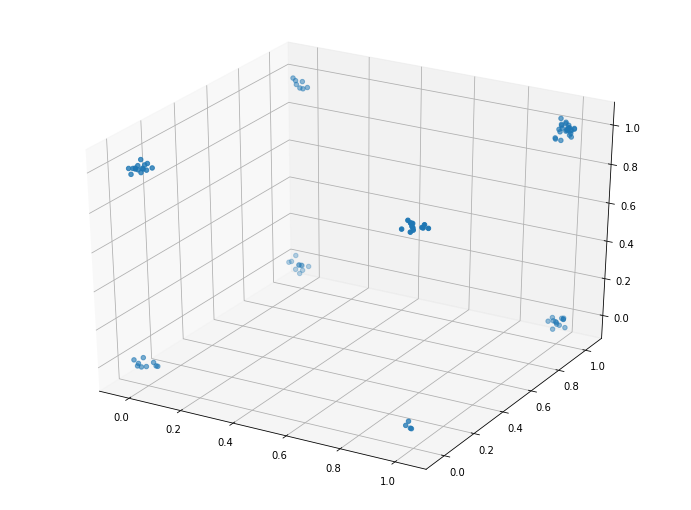

In [67]:
plot_n_samples(1000)

# now, derivation of gradient updates

# compare true distribution with gibbs chain

In [226]:
model = Model(weights=weights, biases=biases)

distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]
distribution

[(array([0, 0, 0]), 0.11615931636074588),
 (array([0, 0, 1]), 0.057110622073371045),
 (array([0, 1, 0]), 0.3907441960969182),
 (array([0, 1, 1]), 0.15028128225645337),
 (array([1, 0, 0]), 0.021976978234447768),
 (array([1, 0, 1]), 0.004457920417210974),
 (array([1, 1, 0]), 0.22376356448854468),
 (array([1, 1, 1]), 0.0355061200723083)]

In [227]:
model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=1000)

empirical_dist = defaultdict(int)
for sample in model_samples:
    empirical_dist[tuple(sample)] += 1 / len(model_samples)
    
empirical_dist  

defaultdict(int,
            {(0, 1, 0): 0.3877551020408166,
             (0, 0, 1): 0.08163265306122448,
             (0, 1, 1): 0.17346938775510207,
             (1, 0, 0): 0.08163265306122448,
             (1, 1, 1): 0.0510204081632653,
             (1, 1, 0): 0.06122448979591836,
             (0, 0, 0): 0.15306122448979592,
             (1, 0, 1): 0.01020408163265306})

In [216]:
for val, prob in distribution:
    empirical_prob = empirical_dist[tuple(val)]
    print(f'Value: {val}')
    print(f'True probability: {prob}')
    print(f'Empirical probability: {empirical_prob}')
    print(f'Abs difference: {np.abs(prob - empirical_prob)}')
    print('\n')

Value: [0 0 0]
True probability: 0.00010713795806284165
Empirical probability: 0
Abs difference: 0.00010713795806284165


Value: [0 0 1]
True probability: 0.003555895960109449
Empirical probability: 0.02040816326530612
Abs difference: 0.01685226730519667


Value: [0 1 0]
True probability: 3.814717880392546e-06
Empirical probability: 0
Abs difference: 3.814717880392546e-06


Value: [0 1 1]
True probability: 1.0801174616648591e-05
Empirical probability: 0
Abs difference: 1.0801174616648591e-05


Value: [1 0 0]
True probability: 0.0004282757686222244
Empirical probability: 0.01020408163265306
Abs difference: 0.009775805864030837


Value: [1 0 1]
True probability: 0.9956768444821255
Empirical probability: 0.9591836734693886
Abs difference: 0.03649317101273686


Value: [1 1 0]
True probability: 1.0897771213087524e-06
Empirical probability: 0
Abs difference: 1.0897771213087524e-06


Value: [1 1 1]
True probability: 0.00021614016146166644
Empirical probability: 0.01020408163265306
Abs differe

# compare sampling algorithms

## via approximating negative phase via gibbs sampling

In [47]:
updates = []

In [48]:
weights, biases = reset_parameters()

timestamps = []
for i in range(100):
    timestamps.append(time())
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_gibbs_sampling', 'step': i, 'time': timestamps[-1] - timestamps[0]})

-238.0177695501797
-237.23124587181525
-236.31691562767966
-235.53198235806906
-234.69270527974584
-233.87880369956105
-232.99112570753823
-232.15322252134987
-231.3742744386503
-230.55945987720767


## via computing true negative phase

In [49]:
weights, biases = reset_parameters()

timestamps = []
for i in range(100):
    timestamps.append(time())
    weights, biases = update_parameters_with_true_negative_phase(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_true_negative_phase', 'step': i, 'time': timestamps[-1] - timestamps[0]})

-237.99978645928636
-237.28298163202328
-236.571896493321
-235.86646881485564
-235.16663713905433
-234.4723407706549
-233.78351976827355
-233.10011493599646
-232.42206781497865
-231.74932067507416


In [50]:
df = pd.DataFrame(updates)

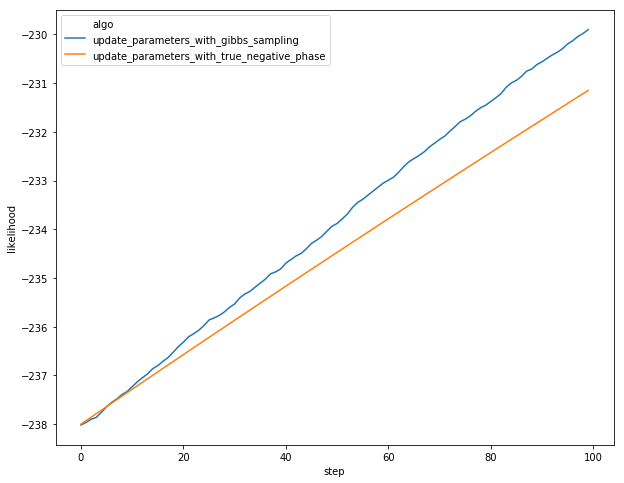

In [51]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="step", y="likelihood", hue="algo", legend='brief', data=df, ci=None)

In [52]:
# plt.figure(figsize=(10, 8))
# ax = sns.lineplot(x="time", y="likelihood", hue="algo", legend='brief', data=df)

# run both for 10 seconds

## via approximating negative phase via gibbs sampling

In [53]:
updates = []

In [54]:
weights, biases = reset_parameters()

timestamps = []
elapsed = 0
while elapsed < 10:
    timestamps.append(time())
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    elapsed = timestamps[-1] - timestamps[0]
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if len(timestamps) % 100 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_gibbs_sampling', 'step': i, 'time': elapsed})

-229.90145810281595
-222.16520933984208
-215.11717380775397
-208.79884936091878
-202.9702339101119
-197.6394267956344
-192.7076707216386
-188.02411800532104
-183.765364563547
-179.63202632668387
-175.89438334904912
-172.42407831105194
-169.15169067681163
-166.06743547315764
-163.12314521606143
-160.41697484722368
-158.02803229667907
-155.61138177529403
-153.33969859038916
-151.1581025429517
-149.2948775193911
-147.34978567079384
-145.5064540889712
-143.69286564313376
-142.0082024598859
-140.43613099621479
-139.03333967507626
-137.66806501532434
-136.29216209883353
-135.03252602595796


## via computing true negative phase

In [55]:
weights, biases = reset_parameters()

timestamps = []
elapsed = 0
while elapsed < 10:
    timestamps.append(time())
    weights, biases = update_parameters_with_true_negative_phase(weights=weights, biases=biases)
    elapsed = timestamps[-1] - timestamps[0]
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if len(timestamps) % 100 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_true_negative_phase', 'elapsed': elapsed, 'step': i, 'time': elapsed})

-231.1483325996702
-224.7446897781177
-218.80816090745716
-213.29230136966055
-208.15616981969112
-203.36364829408924
-198.88283330181758
-194.68549701891516
-190.74661466459457
-187.0439525115451
-183.55771030563847
-180.27021179386495
-177.16563734076684
-174.22979308826928
-171.449911674407
-168.81448010597506
-166.31309093916053
-163.93631343929647
-161.67558185624134
-159.52309836289683
-157.47174856259764
-155.51502778035558
-153.6469766180823
-151.86212448015846
-150.155439968095
-148.52228720625072
-146.95838729884224
-145.45978423557838
-144.02281466233586
-142.64408101722887
-141.32042760352567
-140.04891923116745
-138.8268221098563
-137.65158672021698
-136.5208324266005
-135.4323336267351
-134.38400726043366
-133.37390152269998
-132.40018564640752
-131.46114063676526
-130.5551508544522
-129.68069635695994
-128.83634591861892
-128.02075065926118
-127.23263821968379
-126.4708074292376
-125.73412341708712
-125.02151312412175
-124.33196117726709
-123.66450609210068
-123.01823677

In [56]:
df = pd.DataFrame(updates)

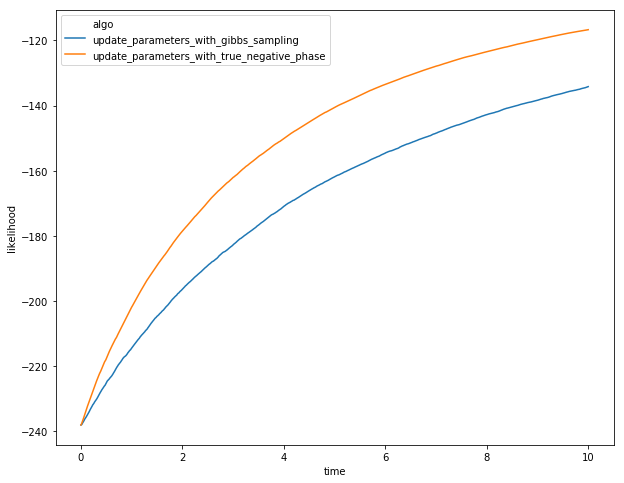

In [57]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="time", y="likelihood", hue="algo", legend='brief', data=df, ci=None)